In [ ]:
"""
%pip install wordcloud
%pip install plotly
%pip install xgboost
%pip install pandas matplotlib seaborn plotly nltk wordcloud scikit-learn numpy scipy

"""

'\n%pip install wordcloud\n%pip install plotly\n%pip install xgboost\n%pip install pandas matplotlib seaborn plotly nltk wordcloud scikit-learn numpy scipy\n\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import style
style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from sklearn.metrics import confusion_matrix,mean_squared_error,precision_score,recall_score,f1_score ,classification_report
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
import pandas as pd

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
df_text=df
df = df.rename(columns={"text": "review" , "label": "sentiment"})
df_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])
df_test = df_test.rename(columns={"text": "review" , "label": "sentiment"})

In [4]:
df.head()

,review,sentiment
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [5]:
df_test["sentiment"].value_counts()

,count
sentiment,
0,12500
1,12500


In [6]:
df["sentiment"].value_counts()

,count
sentiment,
0,12500
1,12500


In [7]:
df.shape

(25000, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


Text(0.5, 1.0, 'Sentiment distribution')

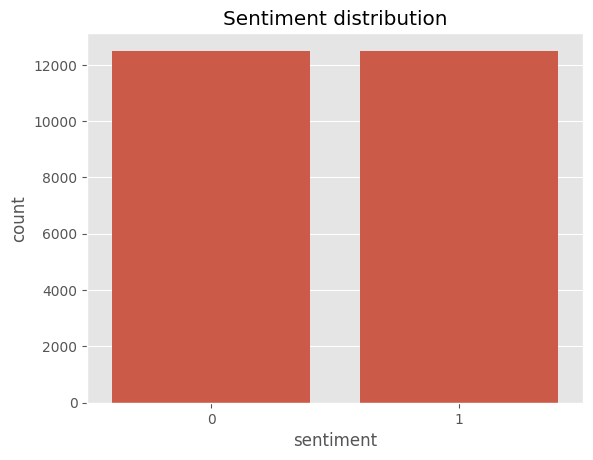

In [9]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment distribution")

In [10]:
for i in range(3):
    print("Review: ", [i])
    print(df['review'].iloc[i], "\n")
    print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")

Review:  [0]
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far

In [11]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [12]:
df['word count'] = df['review'].apply(no_of_words)

In [13]:
df.head()

,review,sentiment,word count
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,288
1,"""I Am Curious: Yellow"" is a risible and preten...",0,214
2,If only to avoid making this type of film in t...,0,93
3,This film was probably inspired by Godard's Ma...,0,118
4,"Oh, brother...after hearing about this ridicul...",0,311


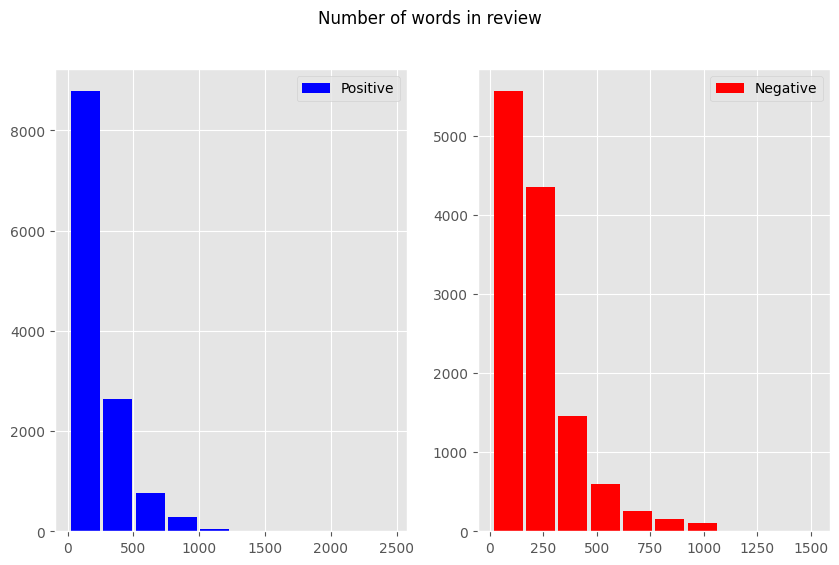

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 1]['word count'], label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 0]['word count'], label='Negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in review")
plt.show()

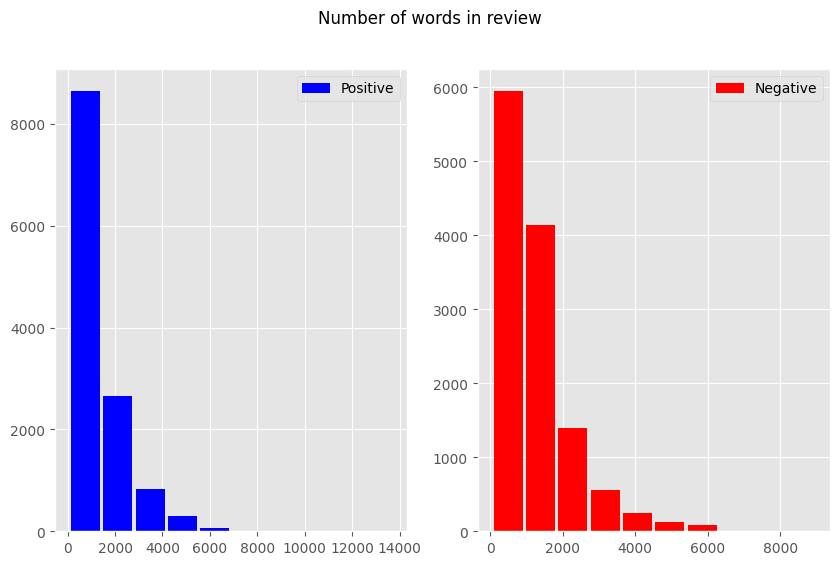

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 1]['review'].str.len(), label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 0]['review'].str.len(), label='Negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in review")
plt.show()

In [16]:
df.head()

,review,sentiment,word count
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,288
1,"""I Am Curious: Yellow"" is a risible and preten...",0,214
2,If only to avoid making this type of film in t...,0,93
3,This film was probably inspired by Godard's Ma...,0,118
4,"Oh, brother...after hearing about this ridicul...",0,311


In [17]:
import nltk
nltk.download('punkt_tab')
def data_processing(text):
    text= text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [18]:
df.review = df['review'].apply(data_processing)
df_test.review =df_test['review'].apply(data_processing)

In [19]:
duplicated_count_train = df.duplicated().sum()
duplicated_count_test = df_test.duplicated().sum()
print("Number of duplicate entries train set: ", duplicated_count_train)
print("Number of duplicate entries test set: ", duplicated_count_test)

Number of duplicate entries train set:  97
Number of duplicate entries test set:  201


In [20]:
df = df.drop_duplicates('review')
df_test = df_test.drop_duplicates('review')

In [21]:
# stemmer = PorterStemmer()
# def stemming(data):
#     text = [stemmer.stem(word) for word in data]
#     return text

In [22]:
stemmer = PorterStemmer()
def stemming(data):
    # Split the text into words
    words = data.split()
    # Apply stemming to each word
    text = [stemmer.stem(word) for word in words]
    return ' '.join(text)

In [23]:
#df.review = df['review'].apply(lambda x: stemming(x))

In [24]:
df['review'] = df['review'].apply(stemming)
df['word count'] = df['review'].apply(no_of_words)

In [25]:
df.head()

,review,sentiment,word count
0,rent curiousyellow video store controversi sur...,0,149
1,curiou yellow risibl pretenti steam pile doesn...,0,119
2,avoid make type film futur film interest exper...,0,47
3,film probabl inspir godard masculin féminin ur...,0,59
4,oh brotheraft hear ridicul film umpteen year t...,0,160


In [26]:
#df_test['word count'] = df_test['review'].apply(no_of_words)
df_test['review'] = df_test['review'].apply(stemming)
df_test['word count'] = df_test['review'].apply(no_of_words)

In [27]:
df_test.head()

,review,sentiment,word count
0,love scifi will put lot scifi moviestv usual u...,0,131
1,worth entertain valu rental especi like action...,0,124
2,total averag film semialright action sequenc m...,0,72
3,star rate saturday night friday night friday m...,0,204
4,first let say havent enjoy van damm movi sinc ...,0,64


In [28]:
pos_reviews =  df[df.sentiment == 0]
pos_reviews.head()

,review,sentiment,word count
0,rent curiousyellow video store controversi sur...,0,149
1,curiou yellow risibl pretenti steam pile doesn...,0,119
2,avoid make type film futur film interest exper...,0,47
3,film probabl inspir godard masculin féminin ur...,0,59
4,oh brotheraft hear ridicul film umpteen year t...,0,160


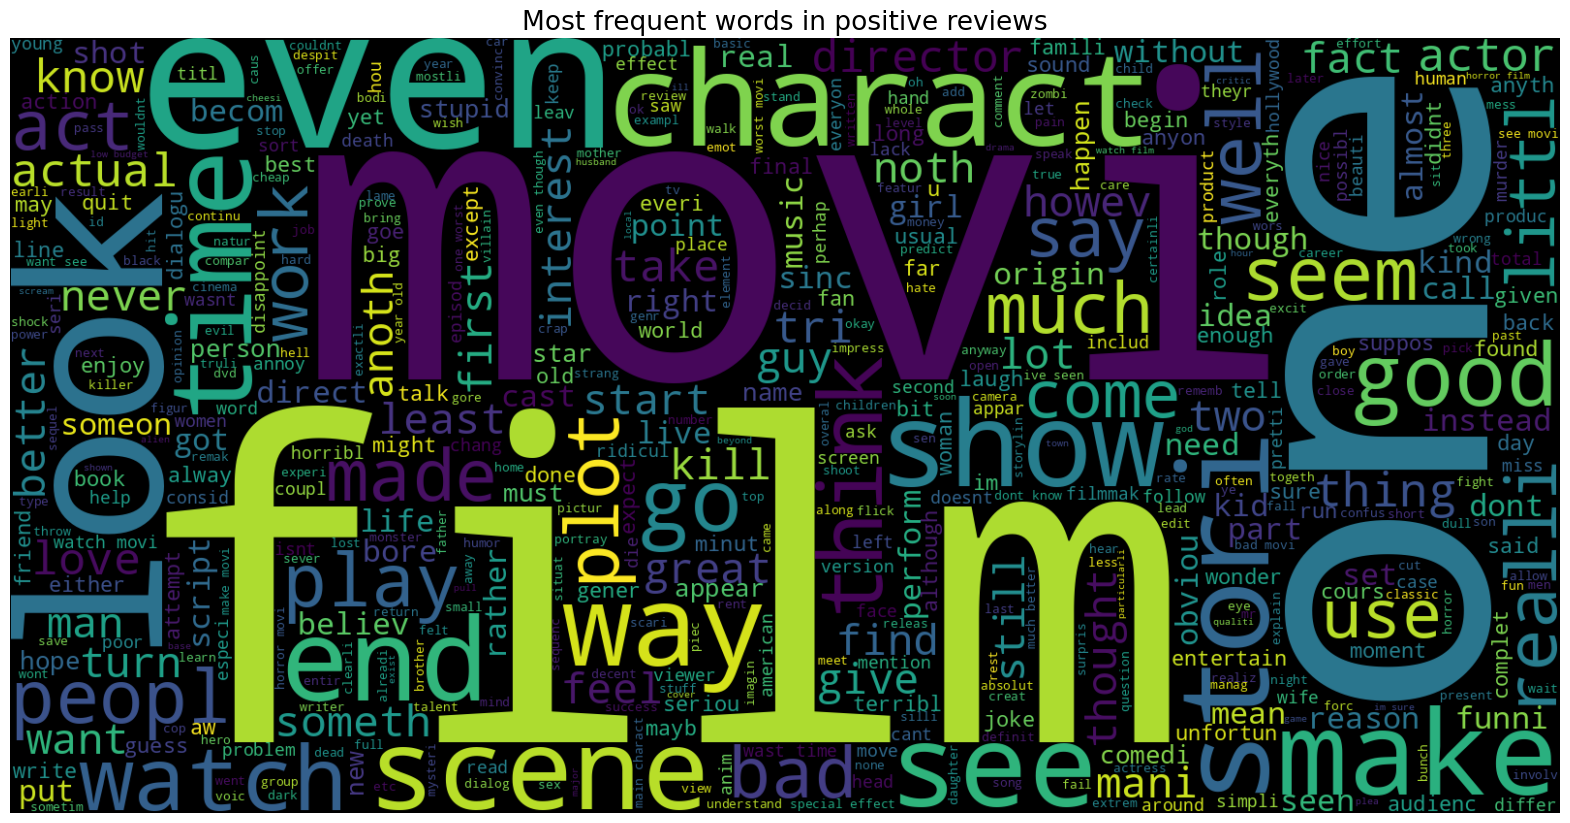

In [29]:
text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

In [30]:
from collections import Counter
count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('movi', 27665),
 ('film', 21820),
 ('one', 12745),
 ('like', 11917),
 ('make', 7804),
 ('even', 7574),
 ('get', 7569),
 ('good', 7206),
 ('watch', 7137),
 ('time', 7134),
 ('bad', 7064),
 ('charact', 6895),
 ('would', 6807),
 ('see', 6479),
 ('realli', 6175)]

In [31]:
pos_words = pd.DataFrame(count.most_common(15))
pos_words.columns = ['word', 'count']
pos_words.head()

,word,count
0,movi,27665
1,film,21820
2,one,12745
3,like,11917
4,make,7804


In [32]:
px.bar(pos_words, x='count', y='word', title='Common words in positive reviews', color = 'word')

In [33]:
neg_reviews =  df[df.sentiment == 1]
neg_reviews.head()

,review,sentiment,word count
12500,zentropa much common third man anoth noirlik f...,1,65
12501,zentropa origin movi ive seen year like uniqu ...,1,60
12502,lar von trier never backward tri new techniqu ...,1,198
12503,contain spoiler due describ film techniqu read...,1,237
12504,first thing sprang mind watch close credit eur...,1,301


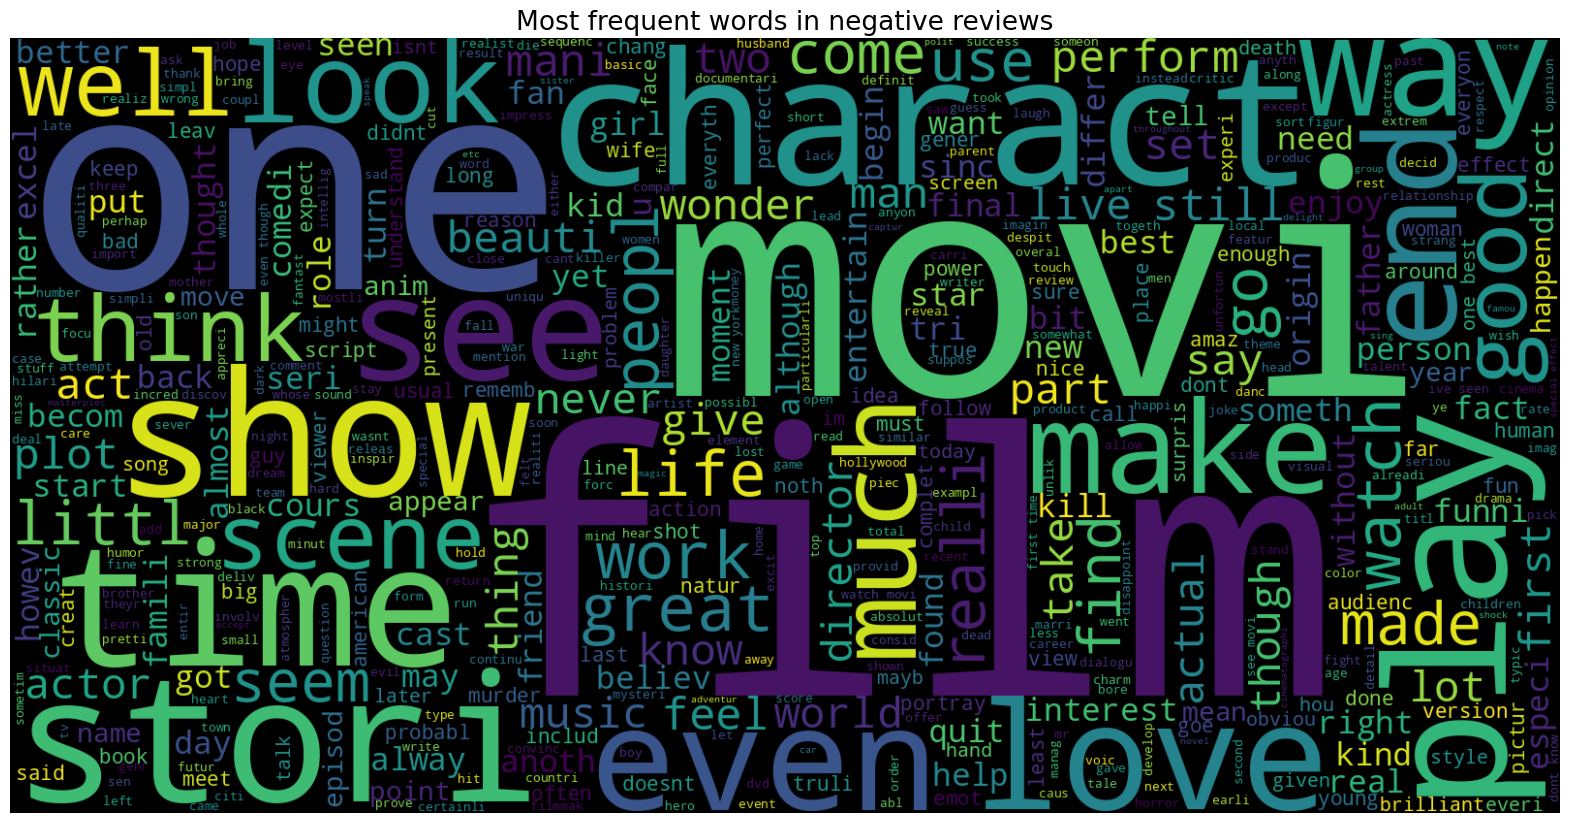

In [34]:
text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

In [35]:

count = Counter()
for text in neg_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('film', 24367),
 ('movi', 21757),
 ('one', 13484),
 ('like', 10077),
 ('time', 7871),
 ('good', 7468),
 ('see', 7240),
 ('stori', 7184),
 ('charact', 6858),
 ('make', 6657),
 ('get', 6412),
 ('watch', 6337),
 ('great', 6308),
 ('love', 5938),
 ('well', 5766)]

In [36]:
neg_words = pd.DataFrame(count.most_common(15))
neg_words.columns = ['word', 'count']
neg_words.head()

,word,count
0,film,24367
1,movi,21757
2,one,13484
3,like,10077
4,time,7871


In [37]:
px.bar(neg_words, x='count', y='word', title='Common words in negative reviews', color = 'word')

In [ ]:
# X = df['review']
# Y = df['sentiment']

vect = TfidfVectorizer()

# Fit-transform the training data and only transform the test data to maintain the same vocabulary
x_train = vect.fit_transform(df['review'])
y_train = df['sentiment']
x_test = vect.transform(df_test['review'])  # Use transform to keep vocabulary consistent with training
y_test = df_test['sentiment']

# Print the sizes to verify the data structure
print("Size of X_train: ", x_train.shape)
print("Size of y_train: ", y_train.shape)
print("Size of X_test: ", x_test.shape)
print("Size of y_test: ", y_test.shape)

In [ ]:
def get_accuracy(name, trained_model , x_train, y_train, x_test, y_test):
    tree_predict = trained_model.predict(x_test)
    print("Testing accuracy   :",metrics.accuracy_score(y_test, tree_predict)*100 , "%")
    print("MSE [TEST]          :",mean_squared_error(y_test, tree_predict))


    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :",metrics.accuracy_score(y_train, tree_predict1)*100 ,"%")
    print("MSE [TRAIN]         :",mean_squared_error(y_train, tree_predict1))

    print("precision : ",precision_score(y_test, tree_predict,average='micro'))
    print("recall    : ",recall_score(y_test, tree_predict,average='micro'))
    print("f1_score  : ",f1_score(y_test, tree_predict,average='micro'))


    cf1 = confusion_matrix(y_test,tree_predict)
    sns.heatmap(cf1,annot=True,fmt = '.0f')
    plt.xlabel('prediction')
    plt.ylabel('Actual')
    plt.title(name+ ' Confusion Matrix')
    plt.show()

    print(classification_report(y_train,  trained_model.predict(x_train)))
    print(classification_report(y_test,  trained_model.predict(x_test)))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

In [ ]:
get_accuracy("logistic regresstion", logreg , x_train, y_train, x_test, y_test)

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb_pred = mnb.predict(x_test)
mnb_acc = accuracy_score(mnb_pred, y_test)
print("Test accuracy: {:.2f}%".format(mnb_acc*100))

In [ ]:
get_accuracy("MultinomialNB", mnb , x_train, y_train, x_test, y_test)

In [ ]:
svc = LinearSVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy: {:.2f}%".format(svc_acc*100))

In [ ]:
get_accuracy("Support vector machine", svc , x_train, y_train, x_test, y_test)

In [ ]:
# Import necessary libraries
import xgboost as xgb

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

# Train the model
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
get_accuracy("xgboost", model , x_train, y_train, x_test, y_test)

In [ ]:
svc = LinearSVC(C = 1, loss='hinge')
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)

In [ ]:
get_accuracy("LinearSVC", svc , x_train, y_train, x_test, y_test)

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Existing accuracy function
def get_accuracy1(name, trained_model, x_train, y_train, x_test, y_test):
    tree_predict = trained_model.predict(x_test)
    print("Testing accuracy   :", metrics.accuracy_score(y_test, tree_predict) * 100, "%")
    print("MSE [TEST]         :", mean_squared_error(y_test, tree_predict))

    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :", metrics.accuracy_score(y_train, tree_predict1) * 100, "%")
    print("MSE [TRAIN]        :", mean_squared_error(y_train, tree_predict1))

    print("Precision          :", precision_score(y_test, tree_predict, average='micro'))
    print("Recall             :", recall_score(y_test, tree_predict, average='micro'))
    print("F1 Score           :", f1_score(y_test, tree_predict, average='micro'))

    cf1 = confusion_matrix(y_test, tree_predict)
    sns.heatmap(cf1, annot=True, fmt='.0f')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title(name + ' Confusion Matrix')
    plt.show()

    print("Training Classification Report:\n", classification_report(y_train, trained_model.predict(x_train)))
    print("Testing Classification Report:\n", classification_report(y_test, trained_model.predict(x_test)))

# Grid search for hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best estimator to fit on training data and evaluate with get_accuracy
best_rf = grid_search.best_estimator_

# Evaluate the best model on the training and test data
get_accuracy1("RandomForestClassifier with GridSearch", best_rf, x_train, y_train, x_test, y_test)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
get_accuracy1("RandomForestClassifier with GridSearch", best_rf, x_train, y_train, x_test, y_test)

In [ ]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [False, True]  # Typically, False for better performance on high-dimensional data
}

# Initialize LinearSVC and GridSearchCV
svc = LinearSVC(random_state=42, max_iter=10000)
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search on training data
grid_search_svc.fit(x_train, y_train)

# Output the best parameters and best cross-validation score
print("Best Parameters for LinearSVC:", grid_search_svc.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_svc.best_score_)

# Get the best estimator and evaluate with get_accuracy1
best_svc = grid_search_svc.best_estimator_


In [ ]:
#get_accuracy1("RandomForestClassifier with GridSearch", best_rf, x_train, y_train, x_test, y_test)

In [ ]:
get_accuracy1("LinearSVC with GridSearch", best_svc, x_train, y_train, x_test, y_test)

In [48]:
# ### Sentiment Analysis with Transformers models pretrained on sentiment analysis tasks

from transformers import pipeline

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df_new = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
df_text=df_new

sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    return_all_scores=True
)


sentiment_classifier(df_text['text'][0])

sentiment_classifier (df_text['text'][0])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[[{'label': 'positive', 'score': 0.3511468470096588},
  {'label': 'neutral', 'score': 0.2291335165500641},
  {'label': 'negative', 'score': 0.4197196364402771}]]

In [ ]:
!pip install -q sentence-transformers datasets

In [ ]:
### Sentence transformer with logistic regression
import re
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from nltk.stem import PorterStemmer
#from sklearn.metrics import classification_report, confusion_matrix

# Train and test datasets
splits = {
    'train': 'plain_text/train-00000-of-00001.parquet',
    'test': 'plain_text/test-00000-of-00001.parquet'
}

# Load the train and test data
df_train = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])

# Rename columns for consistency
df_train = df_train.rename(columns={"text": "review", "label": "sentiment"})
df_test = df_test.rename(columns={"text": "review", "label": "sentiment"})

# Preprocessing function
def data_processing(text):
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stopwords.words('english')]
    return " ".join(filtered_text)

# Apply preprocessing to both train and test sets
df_train['review'] = df_train['review'].apply(data_processing)
df_test['review'] = df_test['review'].apply(data_processing)

# Drop duplicates in train set
df_train = df_train.drop_duplicates('review')

# Stemming function
def stemming(data):
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in data.split()]
    return " ".join(text)

# Apply stemming to both train and test sets
df_train['review'] = df_train['review'].apply(stemming)
df_test['review'] = df_test['review'].apply(stemming)

# Initialize Sentence Transformer model for generating embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for train and test sets separately
X_train = model.encode(df_train["review"].tolist(), batch_size=64, show_progress_bar=True)
Y_train = df_train["sentiment"].values

X_test = model.encode(df_test["review"].tolist(), batch_size=64, show_progress_bar=True)
Y_test = df_test["sentiment"].values

# Train Logistic Regression model on the train embeddings
clf = LogisticRegression(max_iter=100)
clf.fit(X_train, Y_train)

# Predict on the test set
y_pred_test = clf.predict(X_test)

# Evaluate the model
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Model Evaluation")
    print("Accuracy:", metrics.accuracy_score(y_true, y_pred) * 100, "%")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(name + ' Confusion Matrix')
    plt.show()

# Run evaluation on the test set
evaluate_model("Logistic Regression with Sentence Embeddings", Y_test, y_pred_test)

**Sentence transformer**

Used a Sentence Transformer to generate embeddings from IMDB reviews and trained a Logistic Regression model to classify the sentiment.
The use of Sentence Transformers is to help to capture semantic meaning, and the lightweight model provided a balance between efficiency and accuracy for this relatively small dataset.

# **Summary of Commentary on the results:**
After experimenting with multiple ML models the model with best training and testing accuracy are: RandomForestClassifier, and Linear SVC with Training accuracy 99% and test accuracy 89 %. Logistic regression also gave promising results(Training accuracy 93% and test accuracy 89 %).
This result is close to the benchmark of 91%, showcasing a high-performance model given the constraints of training on a CPU within a limited timeframe.
The model’s confusion matrix indicates a balanced performance in classifying positive and negative reviews, while the classification report highlights strong precision and recall across both classes. This demonstrates that the models successfully captures patterns associated with sentiment while maintaining robustness against overfitting.
After reviewing Sentence transformer result it seems that simpler models can effectively capture the specific word patterns and vocabulary associated with positive or negative sentiment in this dataset. The pre-trained sentence transformer embeddings, though powerful for more nuanced language understanding, may not align as well with the task without fine-tuning.

# **Potential Improvements if Time and Resources Were Not an Issue**
With additional resources, the following enhancements could be considered to further boost model accuracy:
More Complex Pre-trained Models: Fine-tuning transformer-based models such as BERT or RoBERTa, DistilBERT, ELECTRA could achieve higher accuracy by leveraging deep contextual embeddings. These models, however, require GPU support and longer training times.
Hyperparameter Optimization: Given more time, a broader hyperparameter search, including methods like RandomizedSearchCV or Bayesian optimization, could fine-tune parameters to higher precision.
Data Augmentation and Expansion: If permitted, additional data sources or data augmentation techniques could enhance generalization.
Also here in all implementation we are taking training and test dataset of equal size (25000 rows for each train and test), if we do the test train split again to take more training data than test data (may be 0.1% test data) that will also allow the models to train on more data points. More training data enables the model to learn richer and more nuanced patterns, which may improve generalization.
**Note:**
I tried different approaches including pretrained models like DistilBERT, BERT with some finetuning, quantization but due to the computational resource limitations I switched to Machine learning models utilizing some pretrained embeddings.
I also tried GloVe embeddings(static word embeddings) that don’t require fine-tuning and are computationally lighter than transformer-based embeddings. But the accuracy in case of pretrained embeddings was not better than the usual ML models like Logistic regression, SVM, Linear SVM etc.
I trained with distilbert and the accuracy was better around 93% but it took around 4-5 hours on CPU to train (Including preprocessing, hyperparameter tuning, quantization early stopping etc) But that was not adhering to the provided requirements of training time less than 2 hours.

# **Python Packages:**
Pandas, matplotlib and seborn helped in data handling and visualization The scikit-learn package was helpful for model development and provided cohesive environment for feature extraction (TfidfVectorizer) and ensemble methods. Hugging Face Datasets enabled easy access to the IMDB dataset. Sentence transformer embeddings from guggingface helped in embedding the reviews.

# **Links to tutorials /Documentation:**
https://huggingface.co/docs/datasets/en/index

scikit-learn Documentation

https://huggingface.co/docs

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2